# Import Required Libraries
Import pandas for data processing, matplotlib for visualization, glob for file handling, and os for path operations.

In [4]:
# Import Required Libraries
import pandas as pd  # For data processing
import matplotlib.pyplot as plt  # For visualization
import glob  # For file handling
import os  # For path operations
import numpy as np  # For numerical operations

# Load CSV Files
Use glob to get all CSV files in the root directory and create a function to read and validate each file's structure.

In [5]:
def load_csv_files():
    csv_files = glob.glob(os.path.join(os.getcwd(), "*.csv"))
    # Prepare df1…df8
    data_frames = {f"df{i}": [] for i in range(1, 9)}
    
    for file in csv_files:
        df = pd.read_csv(file)
        if 'Kills' in df.columns and 'Total Deaths' in df.columns:
            name = os.path.basename(file)
            # Find which Qn_? it is
            for i in range(1, 5):
                prefix = f"CA_Q{i}_"
                if name.startswith(prefix):
                    # Parse the m after the underscore
                    try:
                        m = int(name[len(prefix):-4])  # strip off prefix and “.csv”
                    except ValueError:
                        print(f"Couldn’t parse instance number in {name}, skipping")
                        break

                    # Decide high (m>15) -> df{i+4}, low (m<=15) -> df{i}
                    target = f"df{i}"   if m <= 15 else f"df{i%4 + 1 + 4}"
                    data_frames[target].append(df)
                    print(f"File {name} → {target} (m={m})")
                    break
        else:
            print(f"File {file} does not have the required structure.")
    
    # Now concat each bucket into a real DataFrame
    for i in range(1, 9):
        lst = data_frames[f"df{i}"]
        data_frames[f"df{i}"] = pd.concat(lst, ignore_index=True) if lst else pd.DataFrame()
    
    return data_frames

# Usage
data_frames = load_csv_files()
df1, df2, df3, df4 = data_frames["df1"], data_frames["df2"], data_frames["df3"], data_frames["df4"] # Native quadrants
df5, df6, df7, df8 = data_frames["df5"], data_frames["df6"], data_frames["df7"], data_frames["df8"] # Quadrants shifted by 1

File CA_Q1_1.csv → df1 (m=1)
File CA_Q1_10.csv → df1 (m=10)
File CA_Q1_11.csv → df1 (m=11)
File CA_Q1_12.csv → df1 (m=12)
File CA_Q1_13.csv → df1 (m=13)
File CA_Q1_14.csv → df1 (m=14)
File CA_Q1_15.csv → df1 (m=15)
File CA_Q1_16.csv → df6 (m=16)
File CA_Q1_17.csv → df6 (m=17)
File CA_Q1_18.csv → df6 (m=18)
File CA_Q1_19.csv → df6 (m=19)
File CA_Q1_2.csv → df1 (m=2)
File CA_Q1_20.csv → df6 (m=20)
File CA_Q1_21.csv → df6 (m=21)
File CA_Q1_22.csv → df6 (m=22)
File CA_Q1_23.csv → df6 (m=23)
File CA_Q1_24.csv → df6 (m=24)
File CA_Q1_25.csv → df6 (m=25)
File CA_Q1_26.csv → df6 (m=26)
File CA_Q1_27.csv → df6 (m=27)
File CA_Q1_28.csv → df6 (m=28)
File CA_Q1_29.csv → df6 (m=29)
File CA_Q1_3.csv → df1 (m=3)
File CA_Q1_30.csv → df6 (m=30)
File CA_Q1_4.csv → df1 (m=4)
File CA_Q1_5.csv → df1 (m=5)
File CA_Q1_6.csv → df1 (m=6)
File CA_Q1_7.csv → df1 (m=7)
File CA_Q1_8.csv → df1 (m=8)
File CA_Q1_9.csv → df1 (m=9)
File CA_Q2_1.csv → df2 (m=1)
File CA_Q2_10.csv → df2 (m=10)
File CA_Q2_11.csv → df2 (m=1

# Process Multiple Files
Create DataFrames from each CSV file, extract kills and deaths data, and combine them into a single dataset with proper labeling.

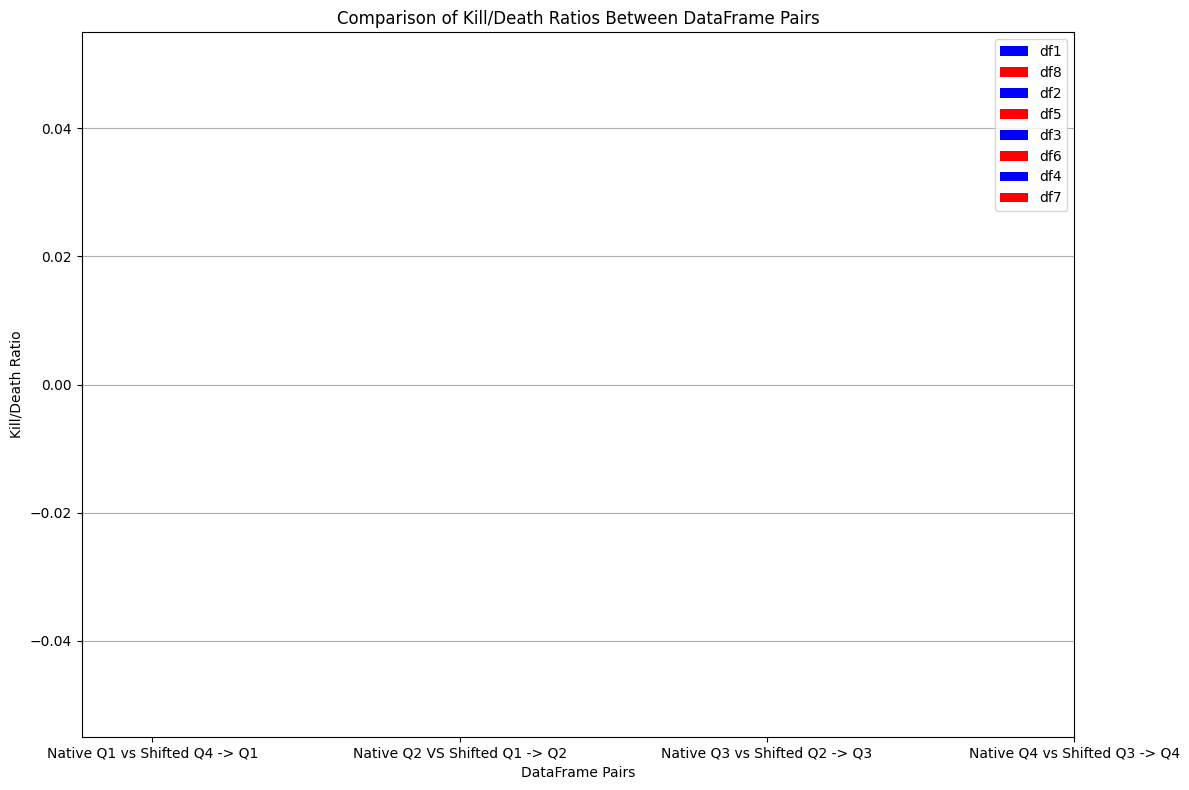


Kill/Death Ratios:
df1: inf
df2: inf
df3: inf
df4: inf
df5: inf
df6: inf
df7: inf
df8: inf

Pair Comparisons:
df1 vs df8: Difference = nan, Percentage = nan%
df2 vs df5: Difference = nan, Percentage = nan%
df3 vs df6: Difference = nan, Percentage = nan%
df4 vs df7: Difference = nan, Percentage = nan%


In [6]:
# Create a KD ratio comparison graph for specified DataFrame pairs

# Calculate KD ratios for each DataFrame
kd_ratios = {}
for i in range(1, 9):
    df_name = f"df{i}"
    df = eval(df_name)  # Get the DataFrame using its variable name
    
    if not df.empty:
        total_kills = df['Kills'].sum()
        total_deaths = df['Total Deaths'].sum() if 'Total Deaths' in df.columns else 0
        
        # Handle division by zero
        kd_ratio = total_kills / total_deaths if total_deaths > 0 else float('inf')
        kd_ratios[df_name] = kd_ratio
    else:
        kd_ratios[df_name] = 0

# Define the pairs to compare
pairs = [('df1', 'df8'), ('df2', 'df5'), ('df3', 'df6'), ('df4', 'df7')]
pair_labels = ['Native Q1 vs Shifted Q4 -> Q1', 'Native Q2 VS Shifted Q1 -> Q2', 'Native Q3 vs Shifted Q2 -> Q3', 'Native Q4 vs Shifted Q3 -> Q4']

# Create a comparison bar chart
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(pairs))

# Create bars for each DataFrame in the pairs
for i, (df1_name, df2_name) in enumerate(pairs):
    plt.bar(index[i], kd_ratios[df1_name], bar_width, label=df1_name, color='blue')
    plt.bar(index[i] + bar_width, kd_ratios[df2_name], bar_width, label=df2_name, color='red')

# Add labels and title
plt.xlabel('DataFrame Pairs')
plt.ylabel('Kill/Death Ratio')
plt.title('Comparison of Kill/Death Ratios Between DataFrame Pairs')
plt.xticks(index + bar_width/2, pair_labels)
plt.grid(True, axis='y')

# Add a legend with a more organized layout
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

# Show values on top of each bar
for i, (df1_name, df2_name) in enumerate(pairs):
    plt.text(index[i], kd_ratios[df1_name] + 0.1, f"{kd_ratios[df1_name]:.2f}", 
             ha='center', va='bottom', fontweight='bold')
    plt.text(index[i] + bar_width, kd_ratios[df2_name] + 0.1, f"{kd_ratios[df2_name]:.2f}", 
             ha='center', va='bottom', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

# Print the exact values for reference
print("\nKill/Death Ratios:")
for df_name, ratio in kd_ratios.items():
    print(f"{df_name}: {ratio:.5f}")

print("\nPair Comparisons:")
for df1_name, df2_name in pairs:
    diff = kd_ratios[df1_name] - kd_ratios[df2_name]
    percent = (diff / kd_ratios[df2_name] * 100) if kd_ratios[df2_name] != 0 else float('inf')
    print(f"{df1_name} vs {df2_name}: Difference = {diff:.5f}, Percentage = {percent:.2f}%")

Determined parameters: 15 members per group, 61 minutes total duration

Data filtering complete. Rows per DataFrame after filtering:
df1: 15 rows
df2: 15 rows
df3: 15 rows
df4: 15 rows
df5: 15 rows
df6: 15 rows
df7: 15 rows
df8: 15 rows


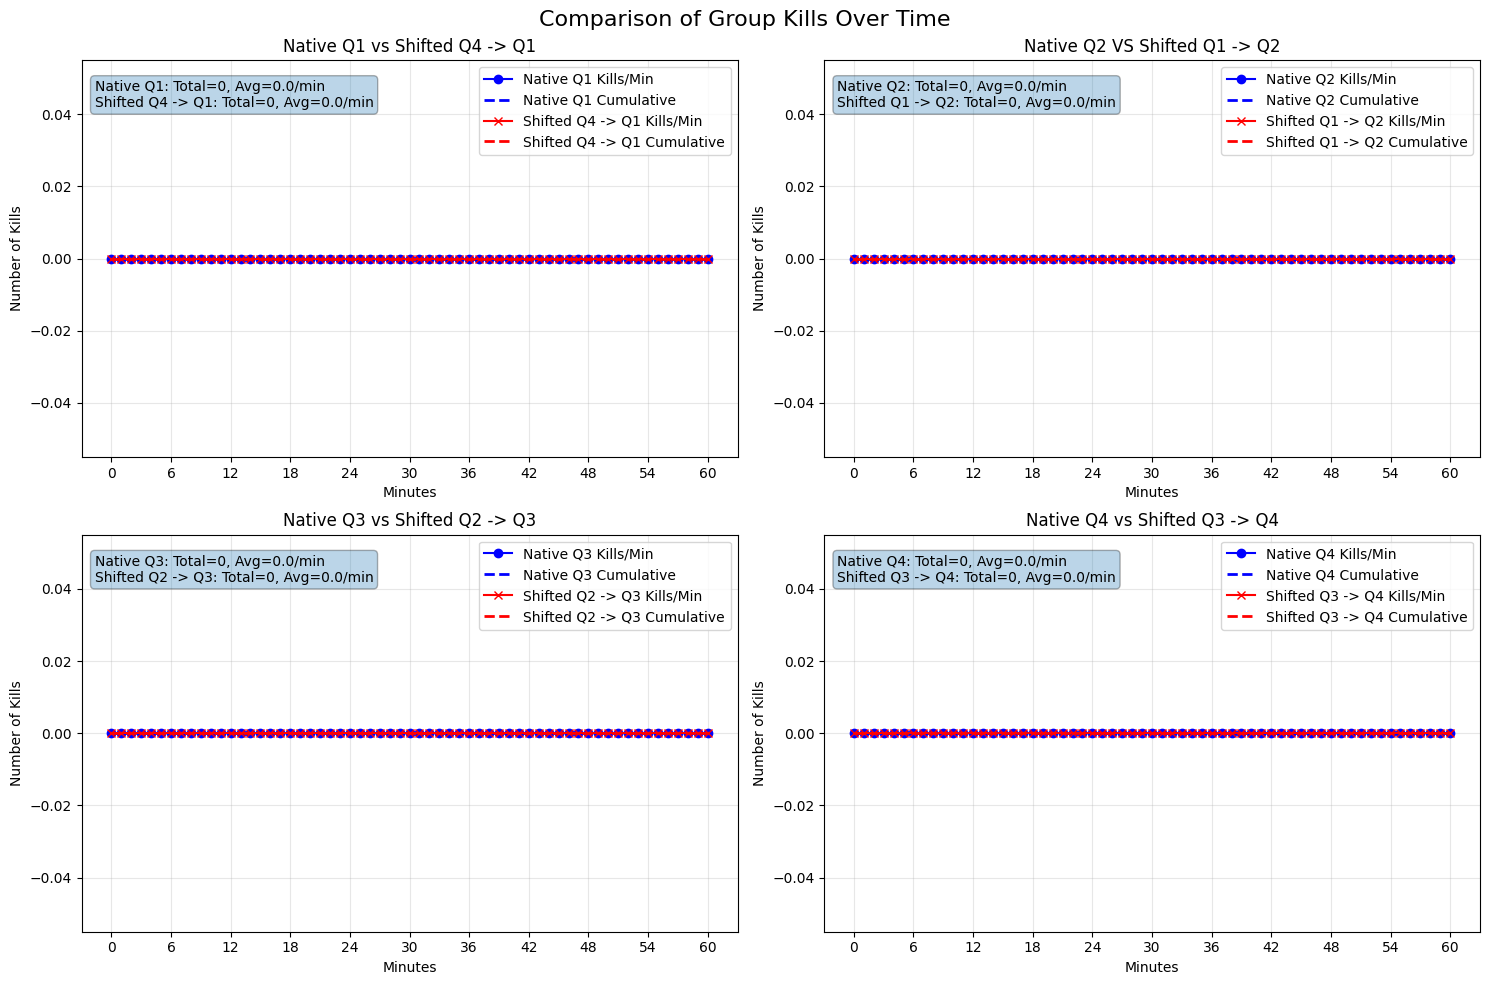


Summary Statistics - Group Kills per Minute:
df1: Total=0, Avg=0.00/min, Max=0/min
df2: Total=0, Avg=0.00/min, Max=0/min
df3: Total=0, Avg=0.00/min, Max=0/min
df4: Total=0, Avg=0.00/min, Max=0/min
df5: Total=0, Avg=0.00/min, Max=0/min
df6: Total=0, Avg=0.00/min, Max=0/min
df7: Total=0, Avg=0.00/min, Max=0/min
df8: Total=0, Avg=0.00/min, Max=0/min


In [ ]:
# Plot kills over time comparisons for each pair
pairs = [('df1', 'df8'), ('df2', 'df5'), ('df3', 'df6'), ('df4', 'df7')]
pair_labels = ['Native Q1 vs Shifted Q4 -> Q1', 'Native Q2 VS Shifted Q1 -> Q2', 'Native Q3 vs Shifted Q2 -> Q3', 'Native Q4 vs Shifted Q3 -> Q4']

# Create a 2x2 grid of subplots for the four comparisons
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()  # Flatten to easily iterate through axes

# Determine experiment parameters dynamically
# Calculate members per group and experiment duration
members_per_group = float('inf')  # Start with infinity
max_minutes = 0

# Find the smallest non-empty DataFrame to determine members per group
# and the minimum time to determine experiment duration
for df_name in ['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8']:
    df = eval(df_name)
    if not df.empty:
        # Count unique timestamps to determine how many members per timestamp
        if 'Time Elapsed' in df.columns:
            timestamps = df['Time Elapsed'].unique()
            if len(timestamps) > 0:
                # Count rows for first timestamp to determine members per group
                first_timestamp = timestamps[0]
                members_count = len(df[df['Time Elapsed'] == first_timestamp])
                members_per_group = min(members_per_group, members_count)
                
                # Find minimum time in minutes
                max_time_seconds = df['Time Elapsed'].max()
                max_time_minutes = max_time_seconds // 60
                max_minutes = max(max(max_minutes, max_time_minutes) - 3, 0) # Takes about 3 minutes to launch everything

# Default values if calculation fails
if members_per_group == float('inf'):
    members_per_group = 16  # Default value
    print("Warning: Could not determine members per group, using default value of 16")

if max_minutes == 0:
    max_minutes = 60  # Default value
    print("Warning: Could not determine experiment duration, using default value of 60 minutes")

print(f"Determined parameters: {members_per_group} members per group, {max_minutes+1} minutes total duration")
minutes = int(max_minutes) + 1  # Add 1 to include minute 0

# Preprocess data - filter each DataFrame to include only the required data
filtered_dfs = {}
for df_name in ['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8']:
    df = eval(df_name)
    if not df.empty and 'Time Elapsed' in df.columns:
        # Filter by time: only include data within the time limit
        max_seconds = max_minutes * 60
        df_filtered_time = df[df['Time Elapsed'] <= max_seconds]
        
        # Filter by members: ensure consistent group size at each timestamp
        filtered_time_points = []
        for time_point in sorted(df_filtered_time['Time Elapsed'].unique()):
            time_group = df_filtered_time[df_filtered_time['Time Elapsed'] == time_point]
            # If we have more members than needed, take only the first members_per_group
            if len(time_group) > members_per_group:
                filtered_time_points.append(time_group.iloc[:members_per_group])
            else:
                filtered_time_points.append(time_group)
        
        # Combine all filtered time points
        if filtered_time_points:
            filtered_dfs[df_name] = pd.concat(filtered_time_points, ignore_index=True)
        else:
            filtered_dfs[df_name] = pd.DataFrame()
    else:
        filtered_dfs[df_name] = pd.DataFrame()

print("\nData filtering complete. Rows per DataFrame after filtering:")
for df_name, df in filtered_dfs.items():
    print(f"{df_name}: {len(df)} rows")

df_identifier = {
    'df1': 'Native Q1',
    'df2': 'Native Q2',
    'df3': 'Native Q3',
    'df4': 'Native Q4',
    'df5': 'Shifted Q1 -> Q2',
    'df6': 'Shifted Q2 -> Q3',
    'df7': 'Shifted Q3 -> Q4',
    'df8': 'Shifted Q4 -> Q1'
    }

# Plot comparison graphs using the filtered data
for i, (df1_name, df2_name) in enumerate(pairs):
    ax = axes[i]
    df1 = filtered_dfs[df1_name]
    df2 = filtered_dfs[df2_name]
    
    # Initialize arrays to store aggregated data
    df1_agg = np.zeros(minutes)
    df2_agg = np.zeros(minutes)
    df1_cumulative = np.zeros(minutes)
    df2_cumulative = np.zeros(minutes)
    
    # Group data by minute and sum kills for each group
    if not df1.empty and 'Time Elapsed' in df1.columns:
        for minute in range(minutes):
            time_seconds = minute * 60
            minute_data = df1[df1['Time Elapsed'] == time_seconds]
            if not minute_data.empty:
                df1_agg[minute] = minute_data['Kills'].sum()
    
    if not df2.empty and 'Time Elapsed' in df2.columns:
        for minute in range(minutes):
            time_seconds = minute * 60
            minute_data = df2[df2['Time Elapsed'] == time_seconds]
            if not minute_data.empty:
                df2_agg[minute] = minute_data['Kills'].sum()
    
    # Calculate cumulative kills
    df1_cumulative = np.cumsum(df1_agg)
    df2_cumulative = np.cumsum(df2_agg)
    
    # Create x-axis representing minutes
    minutes_range = np.arange(minutes)

    # Plot data
    ax.plot(minutes_range, df1_cumulative, label=f'{df_identifier[df1_name]} Cumulative', color='blue', linestyle='--', linewidth=2)
    
    ax.plot(minutes_range, df2_cumulative, label=f'{df_identifier[df2_name]} Cumulative', color='red', linestyle='--', linewidth=2)
    
    # Add labels and grid
    ax.set_xlabel('Minutes')
    ax.set_ylabel('Number of Kills')
    ax.set_title(pair_labels[i])
    ax.grid(True, alpha=0.3)
    ax.set_xticks(np.arange(0, minutes, step=max(1, minutes//10)))  # Set reasonable number of ticks
    ax.legend()
    
    # Add text with statistics
    stats_text = f"{df_identifier[df1_name]}: Total={int(df1_agg.sum())}, Avg={df1_agg.mean():.1f}/min\n"
    stats_text += f"{df_identifier[df2_name]}: Total={int(df2_agg.sum())}, Avg={df2_agg.mean():.1f}/min"
    
    ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox={'boxstyle': 'round', 'alpha': 0.3})

plt.tight_layout()
plt.suptitle(f'Comparison of Group Kills Over Time', fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()

# Print summary statistics for each group
print("\nSummary Statistics - Group Kills per Minute:")
for df_name, df in filtered_dfs.items():
    if not df.empty and 'Time Elapsed' in df.columns:
        # Get unique timestamps in minutes
        timestamps = sorted(df['Time Elapsed'].unique())
        minute_sums = []
        
        for time_seconds in timestamps:
            minute_data = df[df['Time Elapsed'] == time_seconds]
            minute_sums.append(minute_data['Kills'].sum())
        
        if minute_sums:
            minute_sums = np.array(minute_sums)
            total_kills = minute_sums.sum()
            avg_kills = minute_sums.mean()
            max_kills = minute_sums.max()
            
            print(f"{df_name}: Total={total_kills}, Avg={avg_kills:.2f}/min, Max={max_kills}/min")
        else:
            print(f"{df_name}: No data points after filtering")
    else:
        print(f"{df_name}: Empty DataFrame or missing Time Elapsed column")